## Imports

In [157]:
from StringIO import StringIO
import zipfile
import csv
import numpy

import tensorflow as tf

## Parsing IMDB data

In [7]:
%%storage read --object gs://elementai-research-public/imdb-5000-movie-dataset.zip -v imdb_data_raw

In [3]:
imbd_data_zip = zipfile.ZipFile(StringIO(imdb_data_raw))
imbd_data_csv = imbd_data_zip.open('movie_metadata.csv').read()
reader = csv.reader(StringIO(imbd_data_csv))
data = []
for row in reader:
  data.append(row)
header = data[0]
data = data[1:]

## Validation

In [8]:
print ','.join(header)

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes


In [14]:
print ','.join(data[3])

Color,Christopher Nolan,813,164,22000,23000,Christian Bale,27000,448130642,Action|Thriller,Tom Hardy,The Dark Knight Rises ,1144337,106759,Joseph Gordon-Levitt,0,deception|imprisonment|lawlessness|police officer|terrorist plot,http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1,2701,English,USA,PG-13,250000000,2012,23000,8.5,2.35,164000


## Training and test sets

Initialize a training and test set, keeping only numeric data.

In [33]:
training_set_raw, test_set_raw = data[:4500], data[4500:]

In [45]:
numeric_columns = [2,3,4,5,7,8,12,13,15,18,22,23,24,26,27]
def clean(val):
  try:
    return float(val)
  except ValueError:
    return 0.0
def filter_numeric(row):
    return [clean(row[i]) for i in numeric_columns]

In [46]:
training_set = map(filter_numeric, training_set_raw)
training_output = map(lambda row:float(row[25]), training_set_raw)
test_set = map(filter_numeric, test_set_raw)
test_output = map(lambda row:float(row[25]), test_set_raw)

How many dimensions do we have?

In [50]:
len(training_set[120])

15

## Data normalization

In [171]:
def norm(data):
  return numpy.multiply(data, 1.0/numpy.amax(data, axis=0))

training_set = norm(training_set)
test_set = norm(test_set)

## Tensorflow goodness!

In [172]:
# Run this to initialize or reset the session.
try:
  sess.close()
  tf.reset_default_graph()
except NameError:
  pass
sess = tf.InteractiveSession()

In [173]:
x = tf.placeholder(tf.float32, [None, 15])

In [174]:
W = tf.Variable(tf.zeros([15, 1]))
b = tf.Variable(tf.zeros([1]))

In [175]:
temp = tf.matmul(x, W) + b
y = tf.sigmoid(temp)

In [176]:
y_ = tf.placeholder(tf.float32, [None, 1])

In [177]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [178]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [179]:
init = tf.initialize_all_variables()

In [180]:
sess.run(init)

In [182]:
batch_size = 10
num_iter = 1000
assert len(training_set) % batch_size == 0
first_index = 0
loss = []
for i in range(num_iter):
  batch_xs = training_set[first_index:(first_index + batch_size)]
  batch_ys = training_output[first_index:(first_index + batch_size)]
  batch_ys = numpy.reshape(batch_ys, [10, 1])
  #print batch_xs
  #print batch_ys
  first_index = (first_index + batch_size) % len(training_set)
  feed_dict = {x: batch_xs, y_: batch_ys}
  _, curr_loss = sess.run([train_step, cross_entropy], feed_dict = feed_dict)
  #print curr_loss
  loss.append(curr_loss)

0.109957
0.0290998
0.029823
0.0256706
0.0294522
0.0360909
0.031514
0.0344061
0.0327593
0.0332128


## Graph loss

In [132]:
graph = [{'batch': b, 'loss': float(l)} for b, l in zip(range(num_iter), loss)]

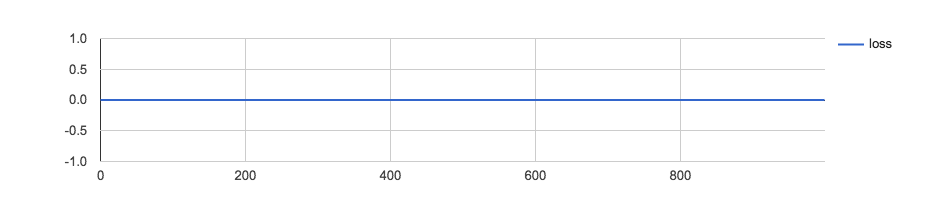

In [98]:
%%chart line --fields batch,loss --data graph